In [11]:
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

In [12]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import tensorflow as tf
from tensorflow.keras.models import Model
from ivae_scorer.datasets import load_kang
from tensorflow.keras import callbacks
from ivae_scorer.utils import set_all_seeds
from ivae_scorer.bio import get_adj_matrices, sync_gexp_adj, build_hipathia_renamers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv
from pathlib import Path
import pandas as pd
import numpy as np



project_path = Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("results")
results_path.mkdir(exist_ok=True, parents=True)
data_path = project_path.joinpath("data")
data_path.mkdir(exist_ok=True, parents=True)
figs_path = results_path.joinpath("figs")
figs_path.mkdir(exist_ok=True, parents=True)
tables_path = results_path.joinpath("tables")
tables_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.9.3 anndata==0.10.3 umap==0.5.5 numpy==1.23.5 scipy==1.10.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.14.1 python-igraph==0.10.3 pynndescent==0.5.11


In [13]:
adata = load_kang(data_folder=data_path, normalize=True, n_genes=4000)

/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [14]:
x_trans = adata.to_df()

In [15]:
circuit_adj, circuit_to_pathway_adj = get_adj_matrices(
    gene_list=x_trans.columns.to_list()
)

circuit_adj.head()

circuit,P-hsa03320-62,P-hsa03320-45,P-hsa03320-43,P-hsa03320-23,P-hsa03320-32,P-hsa03320-8,P-hsa03320-7,P-hsa03320-9,P-hsa03320-39,P-hsa03320-38,...,P-hsa05164-41.42,P-hsa05164-47,P-hsa05164-53,P-hsa05164-65.66,P-hsa05164-68,P-hsa05164-70,P-hsa05164-77,P-hsa05164-78,P-hsa05164-90,P-hsa05164-99
symbol,,,,,,,,,,,,,,,,,,,,,
AKT3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TANK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCL2L11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SH2B3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FRAT1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
x_trans.shape, circuit_adj.shape, circuit_to_pathway_adj.shape

((24673, 1820), (1820, 1221), (1221, 93))

In [17]:
obs = adata.obs.copy()

x_train, x_test = train_test_split(
    x_trans.apply(minmax_scale),
    test_size=0.33,
    stratify=obs["cell_type"],
    random_state=42,
)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [18]:
from ivae_scorer.models import build_kegg_vae

vae, encoder, decoder = build_kegg_vae(
    circuits=circuit_adj, pathways=circuit_to_pathway_adj
)

In [19]:
circuit_to_pathway_adj

pathway,hsa03320,hsa04010,hsa04012,hsa04014,hsa04015,hsa04020,hsa04022,hsa04024,hsa04062,hsa04064,...,hsa04960,hsa04961,hsa04962,hsa04970,hsa04971,hsa04972,hsa04973,hsa04976,hsa05100,hsa05164
circuit,,,,,,,,,,,,,,,,,,,,,
P-hsa03320-62,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
P-hsa03320-45,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
P-hsa03320-43,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
P-hsa03320-23,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
P-hsa03320-32,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-hsa05164-70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-hsa05164-77,0,0,1,1,1,0,1,1,1,0,...,1,0,0,0,0,0,1,0,1,1
P-hsa05164-78,0,0,1,1,1,0,1,1,1,0,...,1,0,0,0,0,0,1,0,1,1


In [20]:
batch_size = 32

callback = callbacks.EarlyStopping(
    monitor="val_loss",  # Stop training when `val_loss` is no longer improving
    min_delta=1e-1,  # "no longer improving" being defined as "no better than 1e-5 less"
    patience=100,  # "no longer improving" being further defined as "for at least 3 epochs"
    verbose=0,
)

history = vae.fit(
    x_train.values,
    shuffle=True,
    verbose=0,
    epochs=300,
    batch_size=batch_size,
    callbacks=[callback],
    validation_data=(x_test.values, None),
)

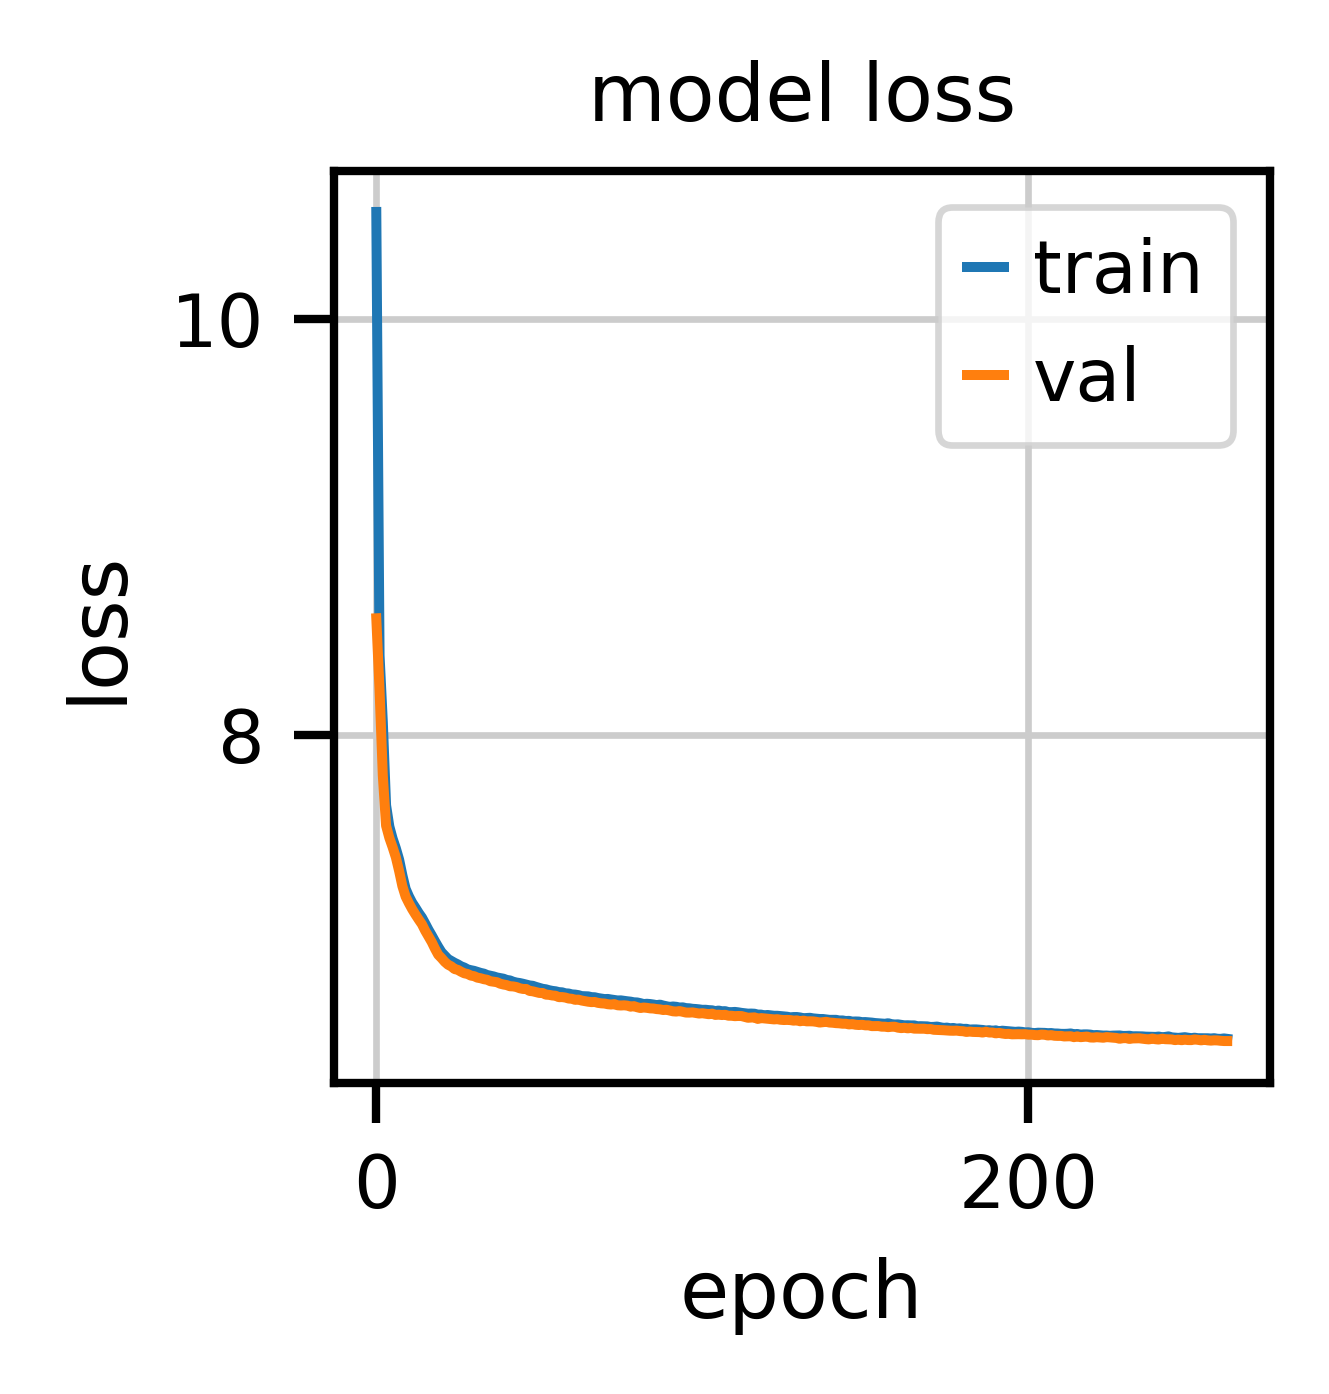

In [21]:
with sns.plotting_context("paper"):
    history.history.keys()
    # summarize history for loss
    plt.figure(figsize=(2, 2))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")

In [22]:

x_train_encoded = encoder.predict(x_train, batch_size=batch_size)[0]
x_train_encoded = pd.DataFrame(x_train_encoded, index=x_train.index)

adata = sc.AnnData(X=x_train_encoded)
adata.obs = obs.loc[x_train.index]

# sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep="X", random_state=42)
sc.tl.leiden(adata, random_state=42)
sc.tl.umap(adata, random_state=42)

517/517 [==============================] - 0s 603us/step


/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
layer_outputs = [layer.output for layer in encoder.layers]
activation_model = Model(inputs=encoder.input, outputs=layer_outputs)

In [24]:
circuit_adj

circuit,P-hsa03320-62,P-hsa03320-45,P-hsa03320-43,P-hsa03320-23,P-hsa03320-32,P-hsa03320-8,P-hsa03320-7,P-hsa03320-9,P-hsa03320-39,P-hsa03320-38,...,P-hsa05164-41.42,P-hsa05164-47,P-hsa05164-53,P-hsa05164-65.66,P-hsa05164-68,P-hsa05164-70,P-hsa05164-77,P-hsa05164-78,P-hsa05164-90,P-hsa05164-99
AKT3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TANK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCL2L11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SH2B3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FRAT1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDC27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RBX1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CDC42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
REC8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# circuit activity extracted from first layer
layer_id = 2

circuit_renamer, pathway_renamer, circuit_to_effector = build_hipathia_renamers()

if layer_id == 1:
    entitie_names = circuit_adj.rename(columns=circuit_renamer).columns

if layer_id == 2:
    entitie_names = circuit_to_pathway_adj.rename(columns=pathway_renamer).columns

517/517 [==============================] - 0s 732us/step


In [33]:
def get_importances(data):
    return np.abs(data).mean(axis=0)

def get_activations(act_model, layer_id, data):
    data_encoded = act_model.predict(data)[layer_id]
    return data_encoded

In [37]:
x_train_encoded = get_activations(act_model=activation_model, layer_id=1, data=x_train)
x_test_encoded = get_activations(act_model=activation_model, layer_id=1, data=x_test)


255/255 [==============================] - 0s 655us/step


In [73]:
stimulated_train_ids = obs.loc[obs["condition"] == "stimulated"].index.intersection(x_train.index)
estimulated_train_encodings = get_activations(act_model=activation_model, layer_id=1, data=x_train.loc[stimulated_train_ids])
estimulated_train_importances = get_importances(estimulated_train_encodings)

258/258 [==============================] - 0s 696us/step


In [74]:
stimulated_test_ids = obs.loc[obs["condition"] == "stimulated"].index.intersection(x_test.index)
estimulated_test_encodings = get_activations(act_model=activation_model, layer_id=1, data=x_test.loc[stimulated_test_ids])
estimulated_test_importances = get_importances(estimulated_test_encodings)

129/129 [==============================] - 0s 660us/step


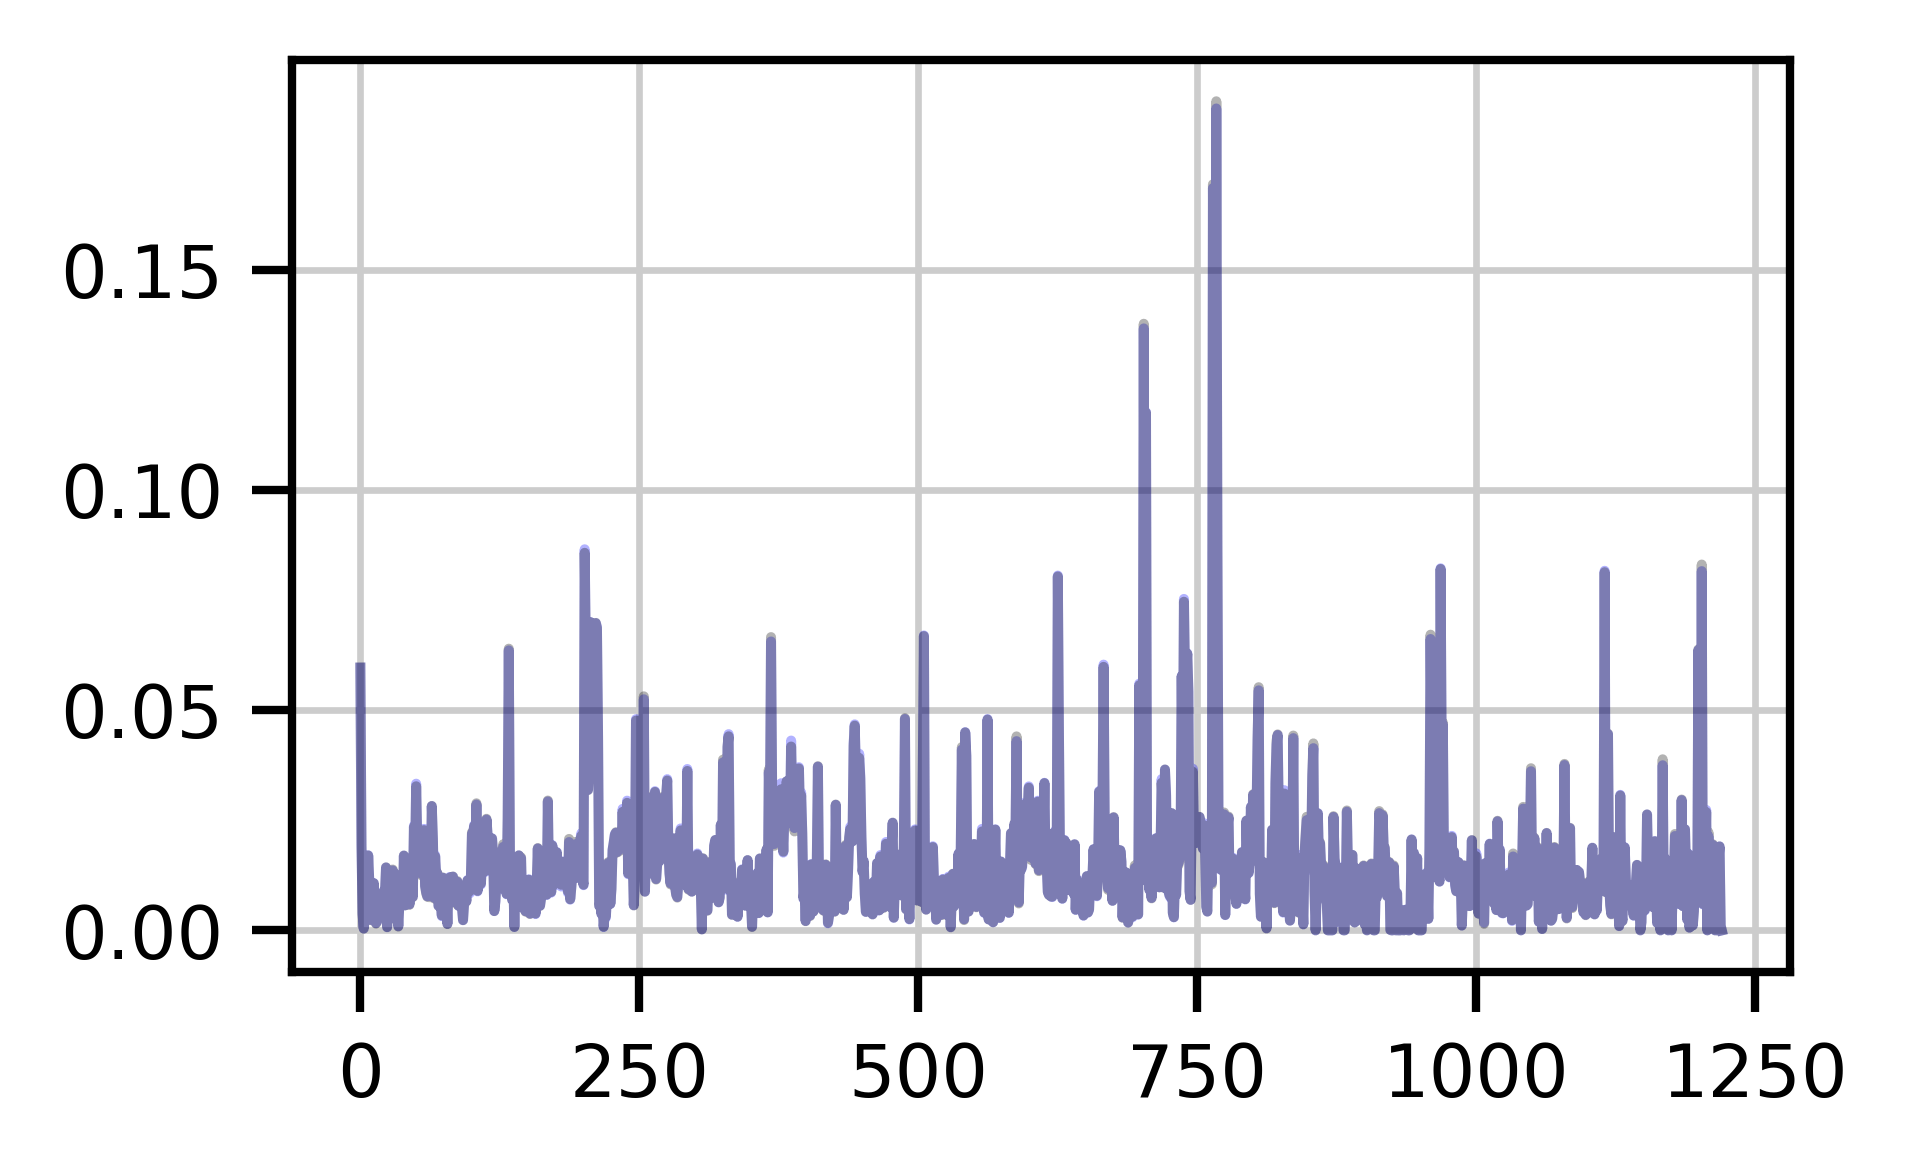

In [81]:
plt.figure(figsize=(16/5, 10/5))

plt.plot(estimulated_test_importances, color="b", alpha=0.3)
plt.plot(estimulated_train_importances, color="k", alpha=0.3)

In [82]:
from scipy.stats import weightedtau

In [83]:
weightedtau(estimulated_test_importances, estimulated_train_importances)

SignificanceResult(statistic=0.9953308657071098, pvalue=nan)